# Stiff coupling

Depending on the charasteristics of the coupling between each submodels, there may be instances where the explicit coupling is higly inefficient and suffers from a tendency to be come unstable. In this tutorial, we explore this issue.

## Toy model : conjugate heat transfer
We consider a one-dimensional test case representing the heat transfer between two solid slabs connected thorugh physical contact surface at $x=0$, as depicted in the following sketch:

For the sake of simplicity, we take similarly-sized grids in both domains, and we use equal properties (thermal conductivity, specific heat) in both, except for the densities. We assume a density of 1 for the second domain, and that of the first domain will be specified (typically 1000 to model the heat transfer between air and an insulating material).


This test case is more complex than the previous mass-spring system, in particular with regards to the handling of the boundary conditions. The interested reader is referred to the vast literature on the topic of conjugate heat transfer simulation. Chapter 8 of this [PhD thesis](https://www.theses.fr/2022IPPAX004) (disclaimer: I am its author :) ) gives an overview of this topic and redirects to relevant articles. In particular, the choice of interface boundary condition is important. Here, we take the usual Neumann-Dirichlet approach.

The model is implemented in the `examples/heat1D` folder of the `Rhapsopy` package. Let us import the necessary modules.

In [21]:
import numpy as np
np.seterr(divide="raise")
import scipy.integrate
import matplotlib.pyplot as plt

from rhapsopy.examples.heat1D.model.setup_heat import getSetup
from rhapsopy.examples.heat1D.model.coupler_heat import Coupler
from rhapsopy.coupling import Orchestrator
from rhapsopy.accelerators import NewtonSolver, DampedNewtonSolver, JFNKSolver, AitkenUnderrelaxationSolver, FixedPointSolver, ExplicitSolver

Let us now set up our model

In [22]:
N=50 # number of grid points in each domain
rho1_sur_rho2 = 1. # ratio of the densities of both solids
tf = 1e3 # physical time simulated
coupling_modes = ('neumann_extrap', 'dirichlet_extrap') # classic coupling-scheme (Neumann-Dirichlet)

# retrieve the data structure for the solvers associated with each slab
options1, options2 = getSetup(N1=N+1,N2=N+1, rho1_sur_rho2=rho1_sur_rho2, bReactive=False)

# instantiate the coupler object
coupler = Coupler(options1, options2, coupling_modes=coupling_modes)
coupler.adaptive_subsolves = True # each subsystem is integrated with adaptive time scheme
coupler.method = 'LSODA' # each subsystem is integrated using Scipy's LSODA scheme

Let us now prepare our simulation orchestrator:

In [23]:
bWR = True # implicit or explicit ?
max_nt = 200 # maximum number of coupling steps allowed
order = 3 # degree of the polynomial approximation of the coupling variables
rtol = 1e-3 # error tolerance for time adaptation
first_step = 1e-4 # size of the first time step to be tried

keepUniformSampling = True # when the time step is changed, the previous sampling points are resampled uniformly (may help with stability)
embedded_method = True # use the embedded error estimate method
higher_order_embedded = True # the embedded method is one order higher than the main method, otherwise it is one order lower

# instantiate the orchestrator class
conductor = Orchestrator(coupler=coupler, order=order)

# specify the error estimation method
conductor.embedded_method = embedded_method
conductor.higher_order_embedded = higher_order_embedded

In the case of an implicit coupling, we need to specify which fixed-point solver must be used. Several options are available in `Rhapsopy` as the following classes:
- the **standard fixed-point solver** `FixedPointSolver`, which simply naively iterates on each step, each time interpolating the coupling variables of the previous iterate. It may suffer from slow convergence or divergence issues if the time step is too large ;
- the **dynamically-relaxed Aitken fixed-point solver** `AitkenUnderrelaxationSolver`, which improves the convergence of the previous algorithm by using an under-relaxation approach with a dynamically selected relaxation factor ;
- the **basic Newton solver** `NewtonSolver`, which solves the fixed-point with a full newton approach, with a Jacobian update after each Newton step.
- the **Newton solver with damping** `DampedNewtonSolver` which uses a dynamically damped Newton algorithm to improve convergence, and allows for more efficient Jacobian reuse.
- the **Jacobien-Free Newton-Krylov solver** `JFNKSolver` which avoid forming the Jacobian of the fixed-point problem. Currently unpreconditioned.

We currently recommand the Aitken solver or, when its convergence is poor, the damped Newton solver. Interface Quasi-Newton solvers are planned for future updates.

A maximum number of iterations (here defined as the number of subsystem integration calls) can be prescribed. If this number of iteration is reached, the time step is reduced.

The **explicit solver** `ExplicitSolver` is just a dummy class to incorporate the explicit coupling (single fixed-point iteration) in the framework of the implicit coupling.

In [24]:
# Choose the fixed-point solver
if bWR: # implicit coupling
  # conductor.interfaceSolver = FixedPointSolver;            conductor.NITER_MAX = 100
  # conductor.interfaceSolver = AitkenUnderrelaxationSolver; conductor.NITER_MAX = 100
  # conductor.interfaceSolver = NewtonSolver;                conductor.NITER_MAX = 15
  conductor.interfaceSolver = DampedNewtonSolver;          conductor.NITER_MAX = 50
  # conductor.interfaceSolver = JFNKSolver;          conductor.NITER_MAX = 50
else: # explicit coupling
  conductor.interfaceSolver = ExplicitSolver

The following block computes some variables which will be useful for post-processing. It also controls the level of printouts issued during the coupled integration.

In [25]:
y0_global = np.hstack( (options1['y0'],
                        options2['y0']) ) # overall initial state vector
x_global =  np.hstack( (options1['solid']['mesh']['cellX'],
                        options2['solid']['mesh']['cellX']) ) # concatenation of both 1D meshes for visualisation

conductor.logger.setLevel(30) # printing level for the orchestration process
conductor.solverlogger.setLevel(100) # printing level for the fixed-point solver
coupler.logger.setLevel(100) # printing level for the coupler

We can now perform the coupled simulation of our system using the `Rhapsopy`package:

In [26]:
outCoupled = conductor.adaptive_integration(y0=y0_global,
                                            t_span=np.array([0.,tf]),
                                            first_step=first_step,
                                            atol=rtol, rtol=rtol,
                                            max_nt=max_nt,
                                            keepUniformSampling=keepUniformSampling)

outCoupled = coupler.complementOutput(outCoupled) # compute additional variables as post-processing

# count total number of subsystem integration calls
nWR = sum(outCoupled.WR_iters)
if conductor.embedded_method: #account for the cost of the embedded method
    nWR2 = sum(outCoupled.WR_iters2)
    nWR = nWR + nWR2

print('Coupled solution obtained in {} s, {} steps ({} accepted, {} rejected, {} failed), {} WR iterations'.format(
       outCoupled.CPUtime, outCoupled.nsteps_total, outCoupled.nsteps_accepted,
       outCoupled.nsteps_rejected, outCoupled.nsteps_failed, nWR))

rhapsopy.coupling - Adaptive integration begins
C:\Anaconda3\envs\baseClone\lib\site-packages\scipy\integrate\_ode.py:1350: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,
rhapsopy.coupling - Adaptive coupled integration has successfully reached end time


Coupled solution obtained in 12.7578284740448 s, 53 steps (49 accepted, 3 rejected, 1 failed), 376 WR iterations


Let us compute a quasi-exact reference solution using a high-order adaptive monolithic integrator:

In [27]:
outRef = scipy.integrate.solve_ivp( fun=lambda t,y: coupler.coupledODE(t=t,y=y),
                                    y0=y0_global, method='LSODA',
                                    t_span=[outCoupled.t[0], outCoupled.t[-1]],
                                    atol=1e-11, rtol=1e-11,
                                    uband=3, lband=3,
                                    dense_output=True)
outRef = coupler.complementOutput(outRef) # compute additional variables as post-processing
assert outRef.success, f'Reference integration failed ({outRef.message})'
print(f'Reference solution obtained in {outRef.nfev} fev')

Reference solution obtained in 1574 fev


We can now compare the surface temperature evolution obtained by both solvers:

Text(0.5, 1.0, 'Evolution of the surface temperature')

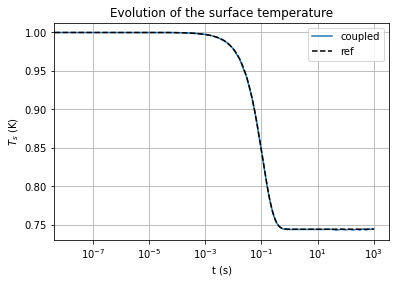

In [28]:
plt.figure()
plt.semilogx(outCoupled.t, outCoupled.Ts, label='coupled')
plt.plot(outRef.t, outRef.Ts, label='ref', linestyle='--', color=[0,0,0])
plt.legend()
plt.xlabel('t (s)')
plt.ylabel(r'$T_s$ (K)')
plt.grid()
plt.title('Evolution of the surface temperature')

The agreement is very good, which shows that our coupled simulation is behaving correctly. We can also compare the temperature profiles in each slab:

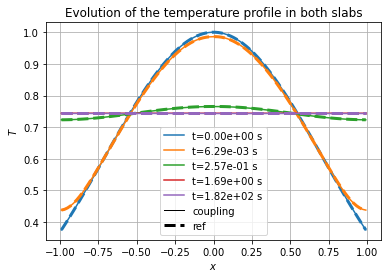

In [29]:
# Show the temporal evolution of the temperature profile
plt.figure()
for i in range(0, len(outCoupled.t)-1, len(outCoupled.t)//5):
    current_t = outCoupled.t[i]
    p, = plt.plot(x_global, outCoupled.y[:,i], marker=None,
                  label='t={:.2e} s'.format(current_t))
    plt.plot(x_global, outRef.sol(current_t), marker=None,
             linestyle='--', linewidth=3,
             color=p.get_color(), label=None)
# hack legend
plt.plot(np.nan, np.nan, linestyle='-', linewidth=1, color=[0,0,0], label='coupling')
plt.plot(np.nan, np.nan, linestyle='--', linewidth=3, color=[0,0,0], label='ref')
plt.grid()
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$T$')
plt.title('Evolution of the temperature profile in both slabs');

It may be useful to analyse the behaviour of our coupled simulation. The following block plots the evolution of the time step used, indicates time steps that were unsuccessful (either due to non-convergence of the fixed-point iteration, or because of an error estimate too large), and shows the evolution of the number of fixed-point iterations required.

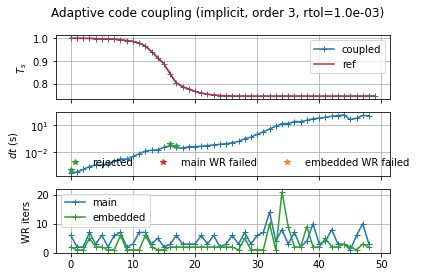

In [30]:
#%% Process detailed step info
from rhapsopy.coupling import process_step_info
step_info = process_step_info(outCoupled)

#%% Analyse time step adaptation
bPlotOrders=False # plot order evolution
bPlotWR=True # plot WR iterations
bPlotStepInfo=True # plot failed steps and others
bTimeAxis=False # plot versus time or index

if bTimeAxis:
  Xdata = outCoupled.t
  Xdataref = outRef.t
  key_infox = 'tn'
else:
  Xdata = np.array(range(outCoupled.t.size))
  # Xdataref = np.array(range(outRef.t.size))
  Xdataref = scipy.interpolate.interp1d(x=outCoupled.t, y=Xdata, kind='linear')( outRef.t ) # sort of equivalence with the coupled solution (based on outCoupled.t)
  # Xdataref = scipy.interpolate.interp1d(x=Ts, y=Xdata, kind='linear', fill_value="extrapolate")( Tsref ) # sort of equivalence with the coupled solution (based on Ts)
  key_infox = 'nt'
  for key in step_info.keys():
    step_info[key]['nt'] = np.array( [ np.argmin(abs(outCoupled.t-t)) for t in step_info[key]['tn'] ] )
    

fig, ax = plt.subplots(2+1*bPlotWR+1*bPlotOrders, 1, sharex=True)

# plot surface temperature
ix=0
ax[ix].plot(Xdata, outCoupled.Ts, marker='+', color='tab:blue', label='coupled')
ax[ix].plot(Xdataref, outRef.Ts, marker=None, color='tab:red', label='ref')
ax[ix].set_ylabel(r'$T_s$')

# plot time step evolution
ix+=1
ax[ix].semilogy(Xdata[:-1], np.diff(outCoupled.t), marker='+', color='tab:blue')
if bPlotStepInfo: # plot failed and refused steps
  ax[ix].semilogy(step_info['ERRORTOOHIGH'][key_infox], step_info['ERRORTOOHIGH']['dt'], marker='*', linestyle='',
                          color='tab:green', label='rejected')
  ax[ix].semilogy(step_info['WRNONCONVERGENCE'][key_infox], step_info['WRNONCONVERGENCE']['dt'], marker='*', linestyle='',
                              color='tab:red', label='main WR failed')
  if conductor.embedded_method:
      ax[ix].semilogy(step_info['WRNONCONVERGENCE2'][key_infox], step_info['WRNONCONVERGENCE2']['dt'], marker='*', linestyle='',
                                  color='tab:orange', label='embedded WR failed')
ax[ix].set_ylabel(r'$dt$ (s)')
ax[ix].grid(which='minor')
ax[ix].legend(framealpha=0, ncol=3)

if bPlotOrders: # plot the evolution of the prediction orders
  ix+=1
  for i in range(  outCoupled.p_hist.shape[1] ):
    ax[ix].plot(Xdata[:-1], outCoupled.p_hist[:,i], marker='+', label=f'var {i}')
  ax[ix].set_ylabel(r'order')
  ax[ix].legend()
  ax[ix].set_ylim(0, order+1)
  ax[ix].set_yticks(range(order+1), minor=True)
  ax[ix].yaxis.grid(which='minor')

if bPlotWR: # plot history of fixed-point iteration count
  ix+=1
  ax[ix].plot(Xdata[:-1], outCoupled.WR_iters, marker='+', color='tab:blue', label='main')
  if conductor.embedded_method:
      ax[ix].plot(Xdata[:-1], outCoupled.WR_iters2, marker='+', color='tab:green', label='embedded')
  ax[ix].legend()
  ax[ix].set_ylabel(r'WR iters')
  ax[ix].set_ylim(0,None)

# finalise visual appearance
ax[0].legend()
for ix in range(len(ax)):
  ax[ix].grid()
if bWR:
    simType='implicit'
else:
    simType='explicit'
fig.suptitle(f'Adaptive code coupling ({simType}, order {conductor.order}, rtol={rtol:.1e})')

if bTimeAxis:
  plt.xlim(outCoupled.t[0], outCoupled.t[-1])

In the explicit case, we see that the time step becomes limited by stability issues. There are a lot of refused steps. This is not the case when we use an implicit algorithm instead. This situtation worsens as the number of cells in each domain is increased.

You can experiment with the order, error tolerance, fixed-point solver, and the various additional options available in the conductor object !